In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/Fibrosis S1-S36_Raw_Data_REC-032321.xlsx
/kaggle/input/drugdata/Mouse_metadata.csv
/kaggle/input/drugdata/Study_results.csv


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# read files
mouse_data = pd.read_csv("/kaggle/input/drugdata/Mouse_metadata.csv")
study_data = pd.read_csv("/kaggle/input/drugdata/Study_results.csv")

mouse_data.head()
study_data.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,0,45.0,0
1,f932,0,45.0,0
2,g107,0,45.0,0
3,a457,0,45.0,0
4,c819,0,45.0,0


In [6]:
# Merge the datasets on 'Mouse ID'
merged_data = pd.merge(mouse_data, study_data, on='Mouse ID', how='inner')

# Show the first few rows of the merged dataset
merged_data.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [7]:
# Check for duplicates based on 'Mouse ID' and 'Timepoint'
duplicates_by_mouse_timepoint = merged_data[merged_data.duplicated(subset=['Mouse ID', 'Timepoint'])]

# Show the number of duplicates
print(f"Number of duplicate rows based on 'Mouse ID' and 'Timepoint': {duplicates_by_mouse_timepoint.shape[0]}")

# Optionally, display the duplicate rows
print(duplicates_by_mouse_timepoint)

Number of duplicate rows based on 'Mouse ID' and 'Timepoint': 5
    Mouse ID Drug Regimen     Sex  Age_months  Weight (g)  Timepoint  \
909     g989     Propriva  Female          21          26          0   
911     g989     Propriva  Female          21          26          5   
913     g989     Propriva  Female          21          26         10   
915     g989     Propriva  Female          21          26         15   
917     g989     Propriva  Female          21          26         20   

     Tumor Volume (mm3)  Metastatic Sites  
909           45.000000                 0  
911           47.570392                 0  
913           49.880528                 0  
915           53.442020                 0  
917           54.657650                 1  


In [8]:
# Remove duplicates based on 'Mouse ID' and 'Timepoint' while keeping the first occurrence
merged_data_cleaned = merged_data.drop_duplicates(subset=['Mouse ID', 'Timepoint'], keep='first')

# Verify that duplicates are removed
print(f"Data after removing duplicates: {merged_data_cleaned.shape[0]}")

Data after removing duplicates: 1888


In [9]:
# Describe the merged dataset and round to 1 decimal place
merged_data_cleaned.describe().round(1)

,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
count,1888.0,1888.0,1888.0,1888.0,1888.0
mean,12.8,25.7,19.6,50.4,1.0
std,7.2,3.9,14.1,8.9,1.1
min,1.0,15.0,0.0,22.1,0.0
25%,7.0,25.0,5.0,45.0,0.0
50%,13.0,27.0,20.0,49.0,1.0
75%,20.0,29.0,30.0,56.3,2.0
max,24.0,30.0,45.0,78.6,4.0


In [10]:
# Get unique drug regimens
unique_drugs = merged_data_cleaned['Drug Regimen'].unique()

# Print unique drug regimens
print("Unique Drug Regimens:")
print(unique_drugs)

Unique Drug Regimens:
['Ramicane' 'Capomulin' 'Infubinol' 'Placebo' 'Ceftamin' 'Stelasyn'
 'Zoniferol' 'Ketapril' 'Propriva' 'Naftisol']


## Placebo vs Ceftamin

In [11]:
# Filter the dataset for 'Ceftamin' drug regimen
Ceftamin_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Ceftamin']

# Get value counts for Age when the drug is Ceftamin
Age_counts_Ceftamin = Ceftamin_data['Age_months'].value_counts()

# Display the result in ascending order
print(Age_counts_Ceftamin.sort_index(ascending=True))

Age_months
2     11
3     14
4     10
5      2
6     25
7     10
11    11
12     7
13     3
15    11
18    10
19    10
20    10
23    11
24    33
Name: count, dtype: int64


In [12]:
# Filter data for Placebo and Ceftamin
placebo_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Placebo']
ceftamin_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Ceftamin']

# Combine both datasets to include Placebo and Ceftamin data
combined_data = pd.concat([placebo_data, ceftamin_data])

# Filter the data for Age_months between 1 and 24
filtered_data = combined_data[combined_data['Age_months'].between(1, 24)]

# Perform value counts for Age_months and Drug Regimen to see at which months both drugs are present
age_drug_counts = filtered_data.groupby('Age_months')['Drug Regimen'].value_counts().unstack(fill_value=0)

# Display the result
print(age_drug_counts)


Drug Regimen  Ceftamin  Placebo
Age_months                     
1                    0       10
2                   11        7
3                   14       13
4                   10        9
5                    2       12
6                   25       13
7                   10       10
9                    0       10
10                   0       10
11                  11        0
12                   7       10
13                   3       10
14                   0        5
15                  11        0
16                   0       12
17                   0       20
18                  10        6
19                  10        4
20                  10       10
21                   0       10
23                  11        0
24                  33        0


<ipython-input-13-72a61a41c49d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  placebo_data['Drug'] = 'Placebo'
<ipython-input-13-72a61a41c49d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ceftamin_data['Drug'] = 'Ceftamin'


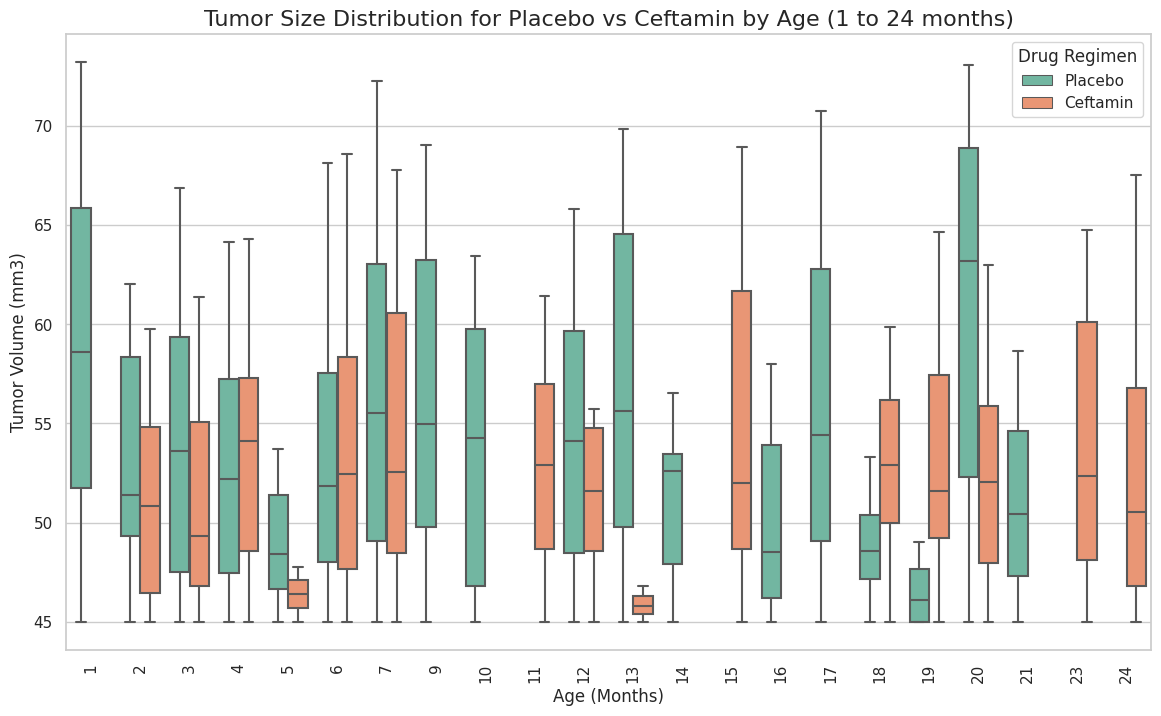

In [13]:
# Set up the plotting style for better visual appearance
sns.set(style="whitegrid")

# Filter data for Placebo and Ceftamin
placebo_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Placebo']
ceftamin_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Ceftamin']

# Combine the Placebo and Ceftamin data into a single dataframe with 'Drug' column to differentiate them
placebo_data['Drug'] = 'Placebo'
ceftamin_data['Drug'] = 'Ceftamin'

# Combine both datasets for plotting
combined_data = pd.concat([placebo_data, ceftamin_data])

# Create a boxplot for tumor volume at each age (1 to 24 months) for both Placebo and Ceftamin
plt.figure(figsize=(14, 8))
sns.boxplot(data=combined_data, x='Age_months', y='Tumor Volume (mm3)', hue='Drug', palette='Set2')

# Add titles and labels
plt.title('Tumor Size Distribution for Placebo vs Ceftamin by Age (1 to 24 months)', fontsize=16)
plt.xlabel('Age (Months)', fontsize=12)
plt.ylabel('Tumor Volume (mm3)', fontsize=12)

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=90)

# Show the plot
plt.legend(title='Drug Regimen')
plt.show()


<ipython-input-15-5338f42225fc>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  placebo_data_2_month['Drug'] = 'Placebo'
<ipython-input-15-5338f42225fc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ceftamin_data_2_month['Drug'] = 'Ceftamin'
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/

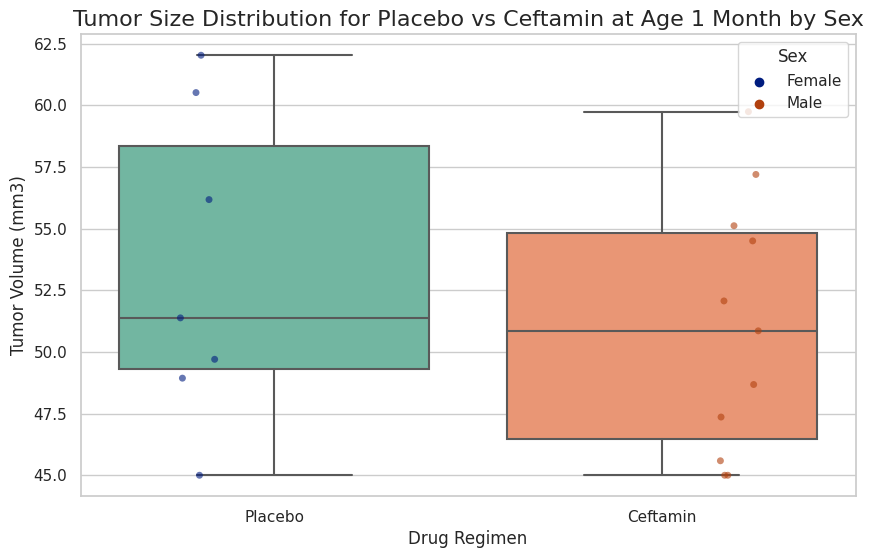

In [15]:
# Age = 2 month

# Filter data for Placebo and Ceftamin
placebo_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Placebo']
ceftamin_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Ceftamin']

# Further filter data for Age = 1 month
placebo_data_2_month = placebo_data[placebo_data['Age_months'] == 2]
ceftamin_data_2_month = ceftamin_data[ceftamin_data['Age_months'] == 2]

# Add 'Drug' column to differentiate between Placebo and Ceftamin
placebo_data_2_month['Drug'] = 'Placebo'
ceftamin_data_2_month['Drug'] = 'Ceftamin'

# Combine both datasets for plotting
combined_data_2_month = pd.concat([placebo_data_2_month, ceftamin_data_2_month])

# Create a boxplot for tumor volume at Age = 1 month, broken down by Drug and Sex
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_data_2_month, x='Drug', y='Tumor Volume (mm3)', 
            palette='Set2', dodge=True)

# Add additional layer for Sex as a subplot, making it facet style
sns.stripplot(data=combined_data_2_month, x='Drug', y='Tumor Volume (mm3)', hue='Sex', 
              dodge=True, marker='o', alpha=0.6, palette='dark')

# Add titles and labels
plt.title('Tumor Size Distribution for Placebo vs Ceftamin at Age 1 Month by Sex', fontsize=16)
plt.xlabel('Drug Regimen', fontsize=12)
plt.ylabel('Tumor Volume (mm3)', fontsize=12)

# Display the legend and show the plot
plt.legend(title='Sex', loc='upper right')
plt.show()


In [16]:
# Filter data for Ceftamin or Placebo and Age = 2 months
ceftamin_placebo_data_age_2 = merged_data_cleaned[(merged_data_cleaned['Drug Regimen'].isin(['Ceftamin', 'Placebo'])) & 
                                                  (merged_data_cleaned['Age_months'] == 2)]

# Group by 'Drug Regimen' and 'Sex' and count the occurrences
sex_by_drug_counts = ceftamin_placebo_data_age_2.groupby(['Drug Regimen', 'Sex']).size().unstack(fill_value=0)

# Display the result
print(sex_by_drug_counts)




Sex           Female  Male
Drug Regimen              
Ceftamin           0    11
Placebo            7     0


In [20]:
# Filter data for Placebo and Ceftamin
placebo_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Placebo']
Ceftamin_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Ceftamin']

# Combine both datasets to include Placebo and Ceftamin data
combined_data = pd.concat([placebo_data, Ceftamin_data])

# Filter the data for Age_months between 1 and 24
filtered_data = combined_data[combined_data['Age_months'].between(1, 24)]

# Perform value counts for Age_months and Drug Regimen to see at which months both drugs are present
age_drug_counts = filtered_data.groupby('Age_months')['Drug Regimen'].value_counts().unstack(fill_value=0)

# Display the result
print(age_drug_counts)

Drug Regimen  Ceftamin  Placebo
Age_months                     
1                    0       10
2                   11        7
3                   14       13
4                   10        9
5                    2       12
6                   25       13
7                   10       10
9                    0       10
10                   0       10
11                  11        0
12                   7       10
13                   3       10
14                   0        5
15                  11        0
16                   0       12
17                   0       20
18                  10        6
19                  10        4
20                  10       10
21                   0       10
23                  11        0
24                  33        0


These months show significant representation of both Ceftamin and Placebo and are thus crucial for further analysis: 2,3,6,12,18,19,20,24

For visualization purpose only these months are used.

<ipython-input-22-b2d39a78ddc6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  placebo_data_age['Drug'] = 'Placebo'
<ipython-input-22-b2d39a78ddc6>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ceftamin_data_age['Drug'] = 'Ceftamin'
<ipython-input-22-b2d39a78ddc6>:32: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=combined_data_age, x='Drug', y='Tumor Volume (mm3)',
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_a

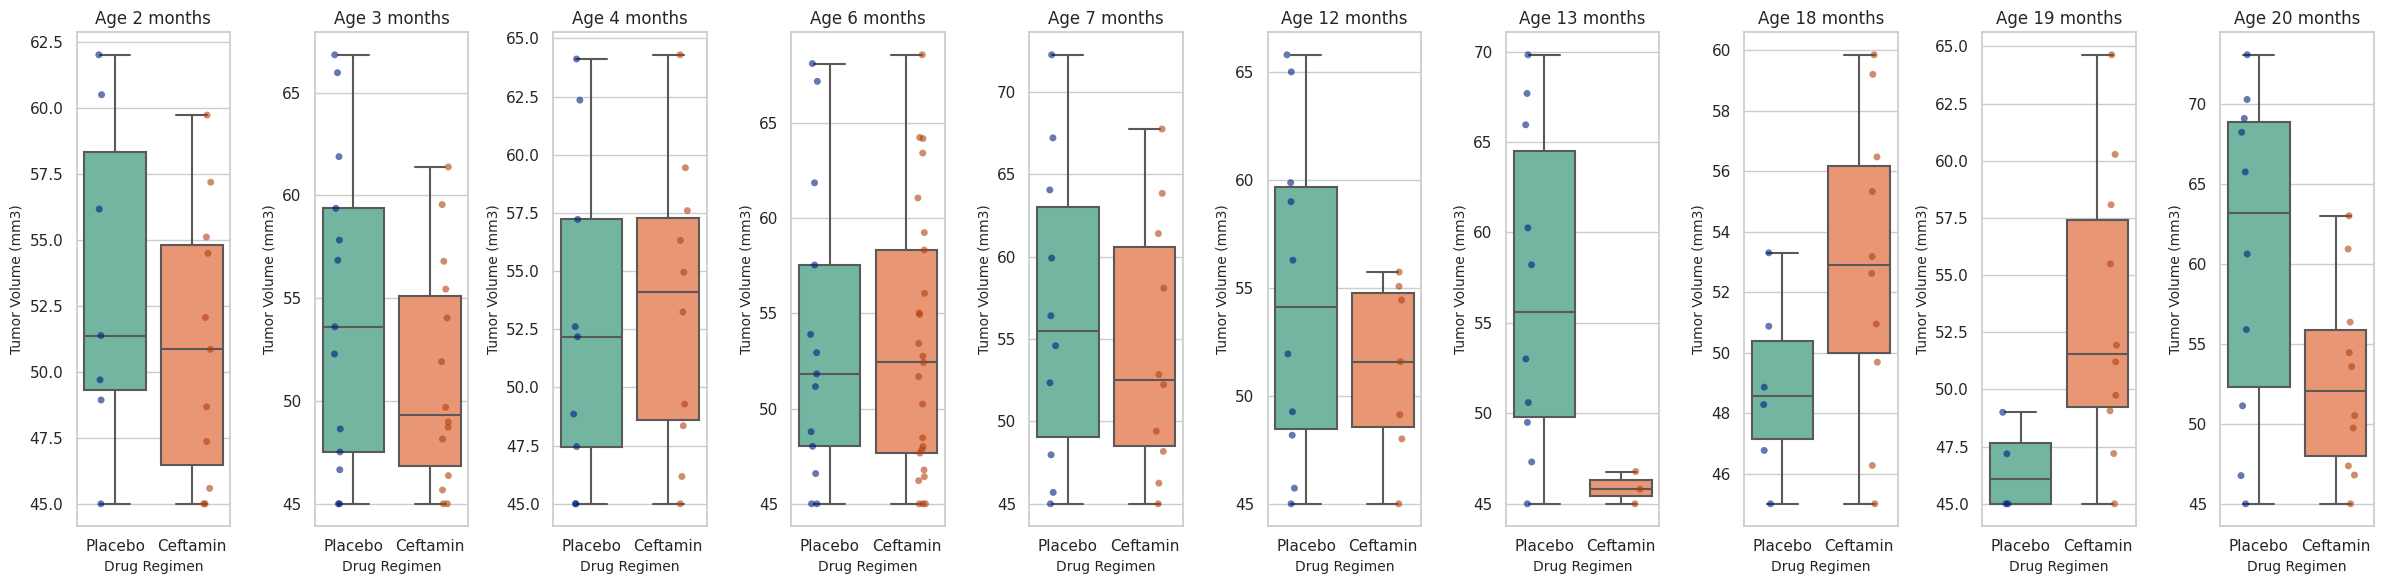

In [22]:
# List of the specific ages to consider
ages_to_plot = [2, 3, 4, 6, 7, 12, 13, 18, 19, 20]

# Filter data for Placebo and Ceftamin
placebo_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Placebo']
ceftamin_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Ceftamin']

# Set up the plot size (9 plots in a single row)
plt.figure(figsize=(24, 6))  # Adjust the width to fit all plots

# Loop through the ages and create the plots
for i, age in enumerate(ages_to_plot):
    # Filter the data for the current age
    placebo_data_age = placebo_data[placebo_data['Age_months'] == age]
    ceftamin_data_age = ceftamin_data[ceftamin_data['Age_months'] == age]

    # Add 'Drug' column to differentiate between Placebo and Ceftamin
    placebo_data_age['Drug'] = 'Placebo'
    ceftamin_data_age['Drug'] = 'Ceftamin'

    # Combine both datasets for the current age
    combined_data_age = pd.concat([placebo_data_age, ceftamin_data_age])

    # Create a subplot (1 row, 10 columns)
    plt.subplot(1, 10, i + 1)

    # Create a boxplot for tumor volume, broken down by Drug
    sns.boxplot(data=combined_data_age, x='Drug', y='Tumor Volume (mm3)', 
                palette='Set2')

    # Add stripplot for additional layer of information
    sns.stripplot(data=combined_data_age, x='Drug', y='Tumor Volume (mm3)', 
                  marker='o', alpha=0.6, palette='dark', dodge=True)
    
    # Add titles and labels
    plt.title(f'Age {age} months', fontsize=12)
    plt.xlabel('Drug Regimen', fontsize=10)
    plt.ylabel('Tumor Volume (mm3)', fontsize=10)
    
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-23-53d106743c9a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  placebo_data_age['Drug'] = 'Placebo'
<ipython-input-23-53d106743c9a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ceftamin_data_age['Drug'] = 'Ceftamin'
<ipython-input-23-53d106743c9a>:30: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=combined_data_age, x='Drug', y='Weight (g)',
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opt

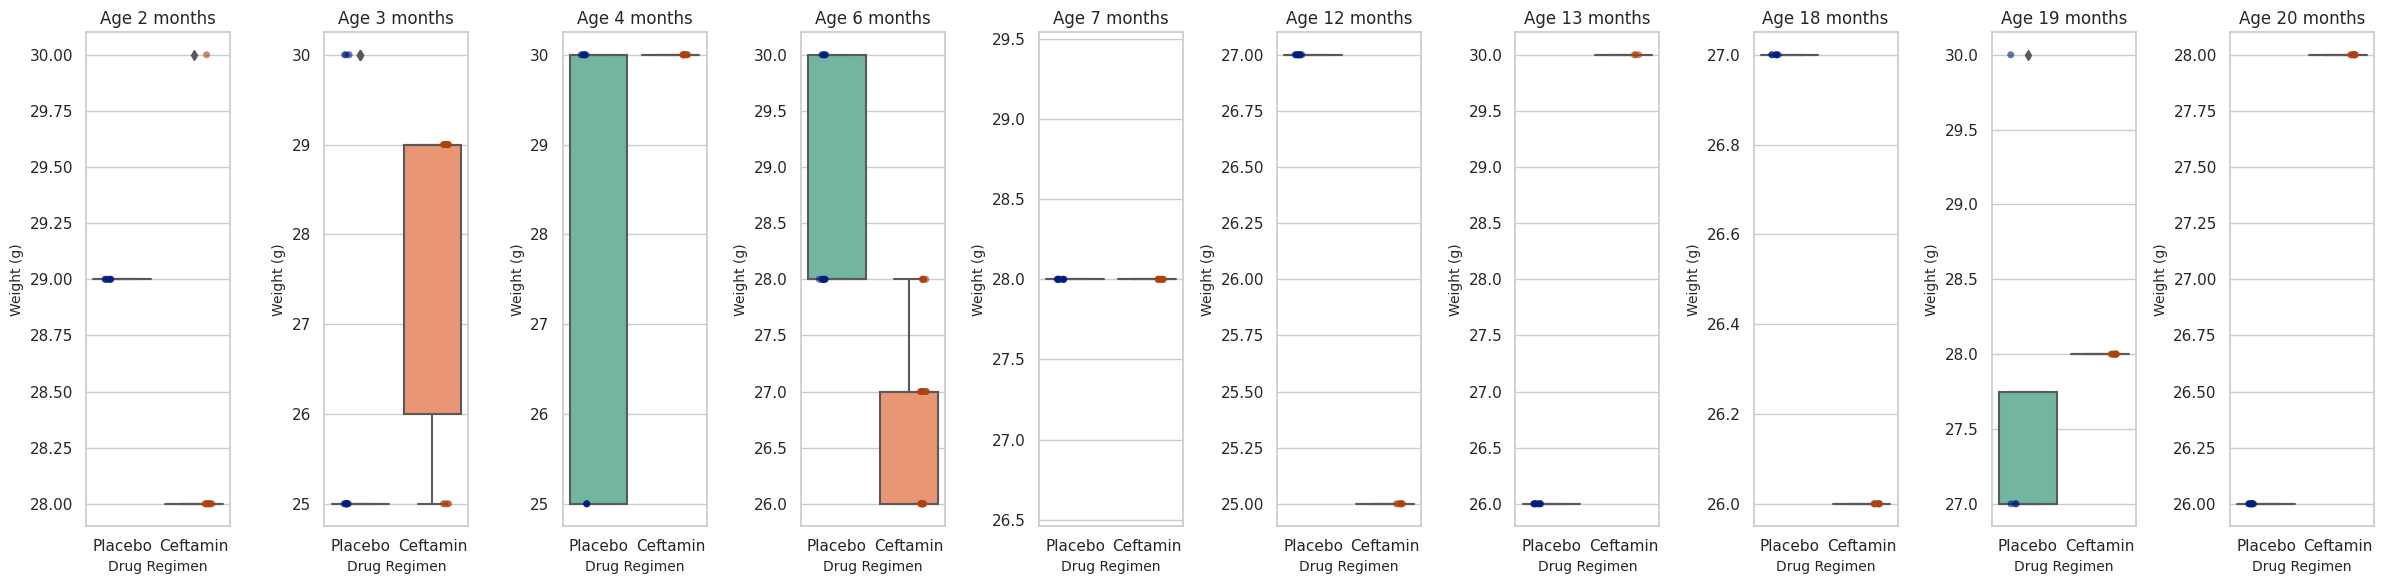

In [23]:
# List of the specific ages to consider
ages_to_plot = [2, 3, 4, 6, 7, 12, 13, 18, 19, 20]

# Filter data for Placebo and Ceftamin (replacing Capomulin with Ceftamin)
placebo_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Placebo']
ceftamin_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Ceftamin']

# Set up the plot size (10 plots in a single row)
plt.figure(figsize=(24, 6))  # Adjust the width to fit all plots

# Loop through the ages and create the plots
for i, age in enumerate(ages_to_plot):
    # Filter the data for the current age
    placebo_data_age = placebo_data[placebo_data['Age_months'] == age]
    ceftamin_data_age = ceftamin_data[ceftamin_data['Age_months'] == age]

    # Add 'Drug' column to differentiate between Placebo and Ceftamin
    placebo_data_age['Drug'] = 'Placebo'
    ceftamin_data_age['Drug'] = 'Ceftamin'

    # Combine both datasets for the current age
    combined_data_age = pd.concat([placebo_data_age, ceftamin_data_age])

    # Create a subplot (1 row, 10 columns)
    plt.subplot(1, 10, i + 1)  # Create a boxplot for weight, broken down by Drug
    sns.boxplot(data=combined_data_age, x='Drug', y='Weight (g)', 
                palette='Set2')

    # Add stripplot for additional layer of information
    sns.stripplot(data=combined_data_age, x='Drug', y='Weight (g)', 
                  marker='o', alpha=0.6, palette='dark', dodge=True)

    # Add titles and labels
    plt.title(f'Age {age} months', fontsize=12)
    plt.xlabel('Drug Regimen', fontsize=10)
    plt.ylabel('Weight (g)', fontsize=10)
    
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [24]:
# Filter data for Placebo and Ceftamin
placebo_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Placebo']
ceftamin_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Ceftamin']

# List of the specific ages to consider
ages_to_plot = [2, 3, 4, 6, 7, 12, 13, 18, 19, 20]

# Loop through each age and get the value counts for Metastatic Sites
for age in ages_to_plot:
    # Filter data for current age and both drug regimens
    placebo_data_age = placebo_data[placebo_data['Age_months'] == age]
    ceftamin_data_age = ceftamin_data[ceftamin_data['Age_months'] == age]
    
    # Combine the data for the current age
    combined_data_age = pd.concat([placebo_data_age, ceftamin_data_age])

    # Get the value counts for Metastatic Sites by drug regimen and age
    metastatic_counts = combined_data_age.groupby(['Age_months', 'Drug Regimen'])['Metastatic Sites'].value_counts().unstack(fill_value=0)
    
    print(f"Metastatic Sites value counts for Age {age} months:")
    print(metastatic_counts)
    print("\n")


Metastatic Sites value counts for Age 2 months:
Metastatic Sites         0  1  2  3  4
Age_months Drug Regimen               
2          Ceftamin      3  2  1  2  3
           Placebo       6  1  0  0  0


Metastatic Sites value counts for Age 3 months:
Metastatic Sites         0  1  2  3
Age_months Drug Regimen            
3          Ceftamin      2  4  7  1
           Placebo       4  9  0  0


Metastatic Sites value counts for Age 4 months:
Metastatic Sites         0  1  2
Age_months Drug Regimen         
4          Ceftamin      4  6  0
           Placebo       3  2  4


Metastatic Sites value counts for Age 6 months:
Metastatic Sites          0   1  2  3  4
Age_months Drug Regimen                 
6          Ceftamin       7  11  2  3  2
           Placebo       10   3  0  0  0


Metastatic Sites value counts for Age 7 months:
Metastatic Sites         0  1  2  3  4
Age_months Drug Regimen               
7          Ceftamin      5  5  0  0  0
           Placebo       1  2  1  4  2


<ipython-input-25-ee5d97eb4fbc>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  placebo_data_age.loc[:, 'Drug'] = 'Placebo'  # Use .loc[] to avoid the warning
<ipython-input-25-ee5d97eb4fbc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ceftamin_data_age.loc[:, 'Drug'] = 'Ceftamin'  # Combine both datasets for the current age
<ipython-input-25-ee5d97eb4fbc>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

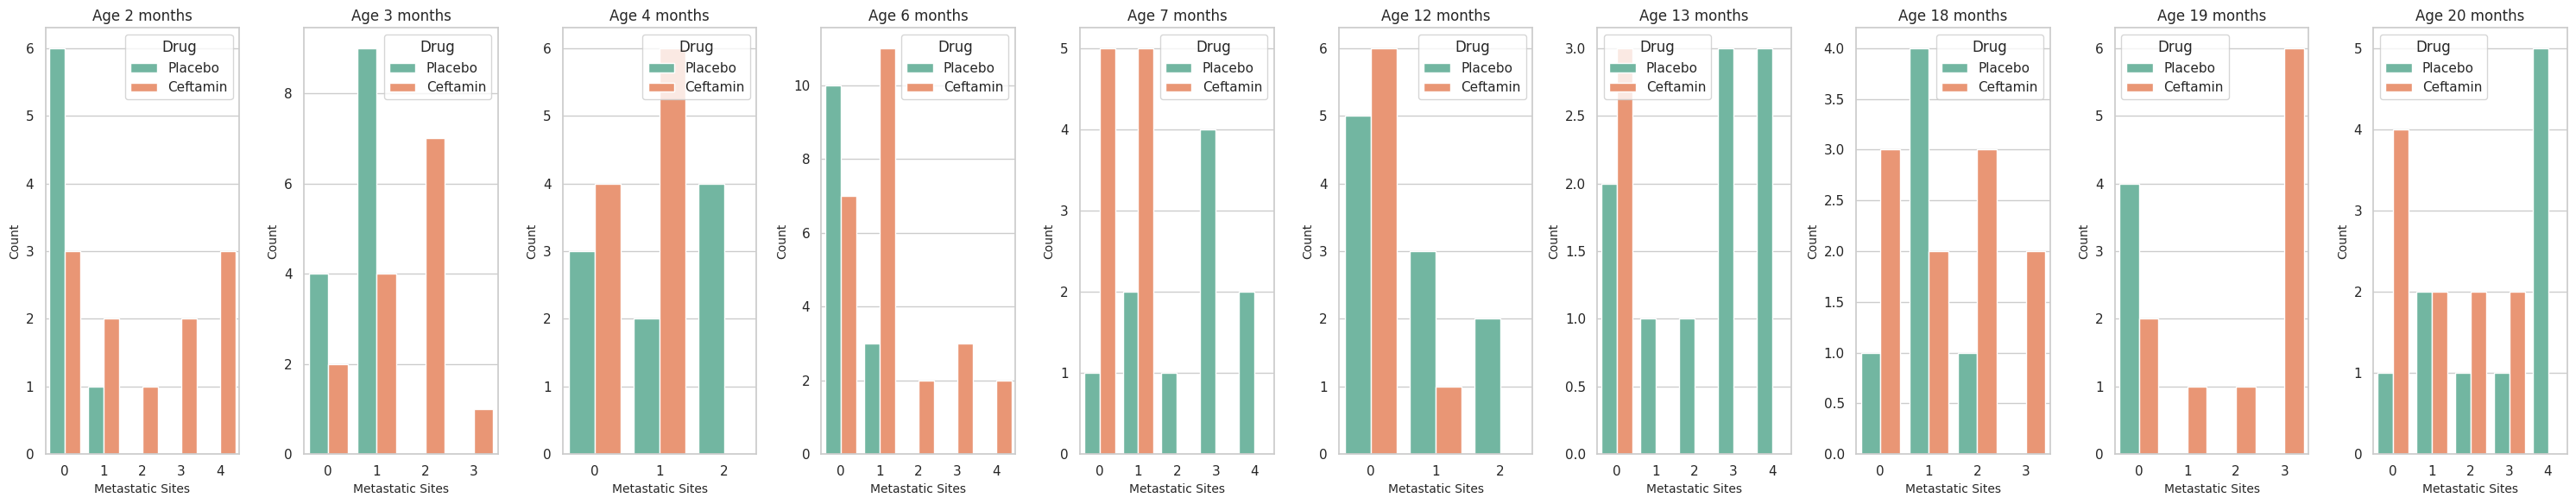

In [25]:
# Metastatic Sites
import warnings

# Suppress SettingWithCopyWarning (optional, if you want to avoid the warnings)
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')


# List of the specific ages to consider
ages_to_plot = [2, 3, 4, 6, 7, 12, 13, 18, 19, 20]

# Filter data for Placebo and Ceftamin
placebo_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Placebo']
ceftamin_data = merged_data_cleaned[merged_data_cleaned['Drug Regimen'] == 'Ceftamin']

# Set up the plot size (10 plots in a single row)
plt.figure(figsize=(30, 6))  # Adjust the width to fit all 10 plots

# Loop through the ages and create the plots
for i, age in enumerate(ages_to_plot):
    # Filter the data for the current age
    placebo_data_age = placebo_data[placebo_data['Age_months'] == age]
    ceftamin_data_age = ceftamin_data[ceftamin_data['Age_months'] == age]

    # Add 'Drug' column to differentiate between Placebo and Ceftamin
    placebo_data_age.loc[:, 'Drug'] = 'Placebo'  # Use .loc[] to avoid the warning
    ceftamin_data_age.loc[:, 'Drug'] = 'Ceftamin'  # Combine both datasets for the current age
    combined_data_age = pd.concat([placebo_data_age, ceftamin_data_age])

    # Create a subplot (1 row, 10 columns)
    plt.subplot(1, 10, i + 1)  # Create a countplot for Metastatic Sites
    sns.countplot(data=combined_data_age, x='Metastatic Sites', hue='Drug', 
                  palette='Set2')

    # Add titles and labels
    plt.title(f'Age {age} months', fontsize=12)
    plt.xlabel('Metastatic Sites', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

